In [10]:
import geopandas as gpd
import pandas as pd
import fiona
import matplotlib.pyplot as plt
import matplotlib
from shapely.geometry import Point
from tqdm import tqdm
from rasterio.plot import show
import rasterio
import numpy as np
import yaml
import os

# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

african_isos = [
    'DZA', 'AGO', 'BEN', 'BWA', 'BFA', 'BDI', 'CPV', 'CMR', 'CAF', 'TCD', 'COM', 'COD', 'DJI', 'EGY', 'GNQ', 'ERI', 
    'SWZ', 'ETH', 'GAB', 'GMB', 'GHA', 'GIN', 'GNB', 'CIV', 'KEN', 'LSO', 'LBR', 'LBY', 'MDG', 'MWI', 'MLI', 'MRT', 
    'MUS', 'MAR', 'MOZ', 'NAM', 'NER', 'NGA', 'RWA', 'STP', 'SEN', 'SYC', 'SLE', 'SOM', 'ZAF', 'SSD', 'SDN', 'TZA', 
    'TGO', 'UGA', 'ZMB', 'ZWE'
]

##### Filter the dam data

In [11]:
global_dams = pd.read_csv(resolve_path(config['Global_Dam_Data_csv_path']))
#print(global_dams.head())

# Strip whitespace from ISO column just in case
global_dams['ISO'] = global_dams['ISO'].str.strip()

#print(global_dams.head())

# Filter for African dams
africa_dams = global_dams[global_dams['ISO'].isin(african_isos)].copy()

#print(africa_dams.head())

# Filter and keep only the necessary columns
filtered_data = africa_dams[['Country', 'Purpose', 'ISO', 'Long__res_', 'Lat__res_']]

#filtered_data.columns = filtered_data.columns.str.strip()

# Ensure Long__res_ and Lat__res_ are treated as numeric using .loc
filtered_data.loc[:, 'Long__res_'] = pd.to_numeric(filtered_data['Long__res_'], errors='coerce')
filtered_data.loc[:, 'Lat__res_'] = pd.to_numeric(filtered_data['Lat__res_'], errors='coerce')

# Exclude rows where both 'Long__res_' and 'Lat__res_' are 0
filtered_data = filtered_data[(filtered_data['Long__res_'] != 0) | (filtered_data['Lat__res_'] != 0)].copy()

filtered_data.to_csv(resolve_path(config['Africa_Dam_csv_path']), index = False)



# Filter dams where the 'Purpose' column contains the word 'Irrigation'
filtered_data_irrigation = filtered_data[filtered_data['Purpose'].str.contains('Irrigation', case=False, na=False)]

print(filtered_data_irrigation.head())

filtered_data_irrigation.to_csv(resolve_path(config['Africa_Dam_Irrigation_csv_path']), index = False)



# Filter dams where the 'Purpose' =='Irrigation'
filtered_data_irrigation_only = filtered_data[filtered_data['Purpose'] == 'Irrigation']

print(filtered_data_irrigation_only.head())

filtered_data_irrigation_only.to_csv(resolve_path(config['Africa_Dam_Irrigation_Only_csv_path']), index = False)

         Country                               Purpose  ISO Long__res_  \
321     Zimbabwe                Hydropower, Irrigation  ZWE    32.0167   
323         Togo                Irrigation, Hydropower  BEN   1.435166   
324   Mozambique                Hydropower; Irrigation  MOZ  32.143353   
414      Morocco  Hydropower, Irrigation, Water Supply  MAR  -4.676228   
415  Ivory Coast                            Irrigation  CIV  -5.259304   

     Lat__res_  
321     -19.25  
323   7.431467  
324 -23.872949  
414  33.930336  
415   9.565742  
          Country     Purpose  ISO Long__res_  Lat__res_
415   Ivory Coast  Irrigation  CIV  -5.259304   9.565742
416         Egypt  Irrigation  EGY  31.189583  27.202083
424       Algeria  Irrigation  DZA   5.923963   34.85386
426  South Africa  Irrigation  ZAF  20.405208 -33.393856
428  Burkina Faso  Irrigation  BFA  -5.356683  10.590938


Turn the CSV into a GDF and trim to arid regions

In [12]:
# Load the dams data and convert to GeoDataFrame
africa_dams = pd.read_csv(resolve_path(config['Africa_Dam_Irrigation_Only_csv_path']))
geometry = [Point(xy) for xy in zip(africa_dams['Long__res_'], africa_dams['Lat__res_'])]
gdf_dams = gpd.GeoDataFrame(africa_dams, geometry=geometry)
gdf_dams = gdf_dams.set_crs("EPSG:4326")  # Ensure the initial CRS is correct

# Load aridity shapefile
africa_all_arid_shp = gpd.read_file(resolve_path(config['Africa_all_shp_path']))
africa_all_arid_shp.set_crs("EPSG:4326")
print(africa_all_arid_shp.crs)

africa_semi_arid_shp = gpd.read_file(resolve_path(config['Africa_semi_arid_shp_path']))
africa_semi_arid_shp.set_crs("EPSG:4326")
print(africa_semi_arid_shp.crs)

africa_arid_shp = gpd.read_file(resolve_path(config['Africa_arid_shp_path']))
africa_arid_shp.set_crs("EPSG:4326")
print(africa_arid_shp.crs)

africa_hyper_arid_shp = gpd.read_file(resolve_path(config['Africa_hyper_arid_shp_path']))
africa_hyper_arid_shp.set_crs("EPSG:4326")
print(africa_hyper_arid_shp.crs)

# Crop the dams GDF to the shapefile
gdf_dams_all = gpd.sjoin(gdf_dams, africa_all_arid_shp, how="inner", predicate="within")
gdf_dams_all.to_file(resolve_path(config['Africa_Dam_All_Arid_shp_path']))
print(gdf_dams_all.head())

gdf_dams_semi = gpd.sjoin(gdf_dams, africa_semi_arid_shp, how="inner", predicate="within")
gdf_dams_semi.to_file(resolve_path(config['Africa_Dam_Semi_Arid_shp_path']))

gdf_dams_arid = gpd.sjoin(gdf_dams, africa_arid_shp, how="inner", predicate="within")
gdf_dams_arid.to_file(resolve_path(config['Africa_Dam_Arid_shp_path']))

gdf_dams_hyper = gpd.sjoin(gdf_dams, africa_hyper_arid_shp, how="inner", predicate="within")
gdf_dams_hyper.to_file(resolve_path(config['Africa_Dam_Hyper_Arid_shp_path']))

EPSG:4326
EPSG:4326
EPSG:4326
None


/tmp/ipykernel_125306/2247479518.py:26: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_dams_all.to_file(resolve_path(config['Africa_Dam_All_Arid_shp_path']))


        Country     Purpose  ISO  Long__res_  Lat__res_  \
1         Egypt  Irrigation  EGY   31.189583  27.202083   
2       Algeria  Irrigation  DZA    5.923963  34.853860   
3  South Africa  Irrigation  ZAF   20.405208 -33.393856   
4  Burkina Faso  Irrigation  BFA   -5.356683  10.590938   
5  South Africa  Irrigation  ZAF   22.585419 -33.512207   

                     geometry  index_right   FID  
1   POINT (31.18958 27.20208)         2466  2466  
2    POINT (5.92396 34.85386)         2466  2466  
3  POINT (20.40521 -33.39386)         3566  3566  
4   POINT (-5.35668 10.59094)         1462  1462  
5  POINT (22.58542 -33.51221)         3566  3566  


/tmp/ipykernel_125306/2247479518.py:30: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_dams_semi.to_file(resolve_path(config['Africa_Dam_Semi_Arid_shp_path']))
/tmp/ipykernel_125306/2247479518.py:33: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_dams_arid.to_file(resolve_path(config['Africa_Dam_Arid_shp_path']))
/tmp/ipykernel_125306/2247479518.py:35: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  gdf_dams_hyper = gpd.sjoin(gdf_dams, africa_hyper_arid_shp, how="inner", predicate="within")
/tmp/ipykernel_125306/2247479518.py:36: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_dams_hyper.to_file(resolve_path(config['Africa_Dam_Hyper_Arid_shp_p

##### Look at some CPIS to Dam distances

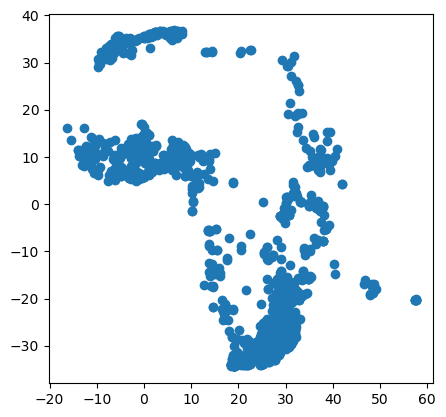

count    32364.000000
mean      4220.502742
std        409.566986
min       1153.010223
25%       4133.059613
50%       4293.381575
75%       4419.583090
max       5465.848190
Name: nearest_dam_distance, dtype: float64


In [35]:
# Load the dams data and convert to GeoDataFrame
africa_dams = pd.read_csv(resolve_path(config['Africa_Dam_csv_path']))
geometry = [Point(xy) for xy in zip(africa_dams['Long__res_'], africa_dams['Lat__res_'])]
gdf_dams = gpd.GeoDataFrame(africa_dams, geometry=geometry)
gdf_dams = gdf_dams.set_crs("EPSG:4326")  # Ensure the initial CRS is correct

gdf_dams.plot()
plt.show()

# Load the CPIS shapefile
gdf_cpis = gpd.read_file(resolve_path(config['Combined_CPIS_shp_path']))

# Ensure both GeoDataFrames use the same CRS (unit in meters instead of degrees)
gdf_dams = gdf_dams.to_crs("EPSG:3857")
gdf_cpis = gdf_cpis.to_crs("EPSG:3857")

# Calculate distances from each CPIS to the nearest dam
gdf_cpis['nearest_dam_distance'] = gdf_cpis.geometry.apply(lambda x: gdf_dams.distance(x).min())/1000

# Statistical summary of distances
distance_summary = gdf_cpis['nearest_dam_distance'].describe()
print(distance_summary)